In [1]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import glob
import time
import pickle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# from sklearn.cross_validation import train_test_split  # for scikit-learn version <= 0.17
from sklearn.model_selection import train_test_split  # if you are using scikit-learn >= 0.18

## Feature extraction functions

In [2]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img,
                                  orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img,
                       orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

    
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))


# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Change image color space
def change_colorspace(img, color_space = 'RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            conv_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            conv_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            conv_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            conv_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            conv_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        conv_image = np.copy(img)
    
    return conv_image


# Extract features from a single image
def extract_features_from_image(img,
                                color_space='RGB',
                                spatial_size=(32, 32),
                                hist_bins=32,
                                orient=9, 
                                pix_per_cell=8,
                                cell_per_block=2,
                                hog_channel='ALL',
                                spatial_feat=True,
                                hist_feat=True,
                                hog_feat=True):
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.array(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
        
    #print("Feature space size:")    
    #print(spatial_features.shape)
    #print(hist_features.shape)
    #print(hog_features.shape)
        
    #9) Return concatenated array of features
    return np.concatenate(img_features)


# Extract features from a list of images
def extract_features_from_image_list(img_file_list,
                                     color_space='RGB',
                                     spatial_size=(32, 32),
                                     hist_bins=32,
                                     orient=9,
                                     pix_per_cell=8,
                                     cell_per_block=2,
                                     hog_channel='ALL',
                                     spatial_feat=True,
                                     hist_feat=True,
                                     hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    
    # Iterate through the list of images
    for img_file in img_file_list:      
        # Read in each one by one
        img = mpimg.imread(img_file)
        # Extract features from each of them
        img_features = extract_features_from_image(img,
                                                   color_space=color_space,
                                                   spatial_size=spatial_size,
                                                   hist_bins=hist_bins,
                                                   orient=orient, 
                                                   pix_per_cell=pix_per_cell,
                                                   cell_per_block=cell_per_block,
                                                   hog_channel=hog_channel,
                                                   spatial_feat=spatial_feat,
                                                   hist_feat=hist_feat,
                                                   hog_feat=hog_feat)
        
        features.append(img_features)
        
    # Return list of feature vectors
    return features

## Object detection functions

In [23]:
# Takes one full camera image and define a grid of search windows.
# There's also the option to scale the image (x/y_start_stop still refer to the original size image)
def prepare_windows(img,
                    x_start_stop=[None, None],
                    y_start_stop=[None, None], 
                    xy_window=(64, 64),
                    xy_overlap=(0.5, 0.5)):
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
    
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
            
    # Return the list of windows
    return window_list
    
    
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_in_windows(img, 
                      windows,
                      clf, 
                      scaler, 
                      color_space='RGB', 
                      spatial_size=(32, 32),
                      hist_bins=32, 
                      hist_range=(0, 256),
                      orient=9, 
                      pix_per_cell=8,
                      cell_per_block=2, 
                      hog_channel=0,
                      spatial_feat=True, 
                      hist_feat=True,
                      hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    
    #2) Iterate over all windows in the list
    for window in windows:
        
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        
        #4) Extract features for that window using extract_features_from_image()
        features = extract_features_from_image(test_img,
                                               color_space=color_space, 
                                               spatial_size=spatial_size,
                                               hist_bins=hist_bins, 
                                               orient=orient,
                                               pix_per_cell=pix_per_cell, 
                                               cell_per_block=cell_per_block, 
                                               hog_channel=hog_channel,
                                               spatial_feat=spatial_feat, 
                                               hist_feat=hist_feat,
                                               hog_feat=hog_feat)
        
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
            
    #8) Return windows for positive detections
    return on_windows


# Search the image for cars.
# It uses image-wide hog and crates its own windows.
def search_in_image(img,
                    y_start_stop,
                    color_space,
                    scale,
                    classifier,
                    scaler,
                    window_size=64,
                    hog_channel=[0,1,2],    # Image channels on which we want to compute HOG
                    hog_orient=9,           # HOG possible orientations
                    hog_pix_per_cell=8,     # HOG number of px per cell
                    hog_cell_per_block=2,   # HOG number of cells per block
                    spatial_size=(32,32),   # SPATIAL features resize
                    histogram_bins=32,      # HISTOGRAM number of bins
                    enable_spatial_features=True,
                    enable_hist_features=True,
                    enable_hog_features=True):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[y_start_stop[0]:y_start_stop[1],:,:]
    ctrans_tosearch = change_colorspace(img_tosearch, color_space=color_space)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    # Separate channels
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // hog_pix_per_cell) - hog_cell_per_block + 1
    nyblocks = (ch1.shape[0] // hog_pix_per_cell) - hog_cell_per_block + 1 
    nfeat_per_block = hog_orient*hog_cell_per_block**2
    
    # Compute HOG features over the whole image
    hog1 = get_hog_features(ch1, hog_orient, hog_pix_per_cell, hog_cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, hog_orient, hog_pix_per_cell, hog_cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, hog_orient, hog_pix_per_cell, hog_cell_per_block, feature_vec=False)
    
    # 64 was the original sampling rate, with 8 cells and 8 pix per cell
    nblocks_per_window = (window_size // hog_pix_per_cell) - hog_cell_per_block + 1
    cells_per_step = 4  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Create an empty list to receive positive detection windows
    on_windows = []

    # Iterate over all windows in the list
    for xb in range(nxsteps):
        for yb in range(nysteps):
            
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos * hog_pix_per_cell
            ytop = ypos * hog_pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window_size, xleft:xleft+window_size], (64,64))
          
            # Spatial features
            if enable_spatial_features:
                spatial_features = bin_spatial(subimg, size=spatial_size)
            else:
                spatial_features = []
                
            #print(spatial_features.shape)
                
            # Histogram features
            if enable_hist_features:
                hist_features = color_hist(subimg, nbins=histogram_bins)
            else:
                hist_features = []
                
            #print(hist_features.shape)
            #print(hog_features.shape)
            
            # Stack all features
            features = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            #print(features.shape)
            
            # Scale extracted features to be fed to classifier
            scaled_features = scaler.transform(features)
            
            # Predict using your classifier
            prediction = svc.predict(scaled_features)
            
            # If positive (prediction == 1) then save the window
            if prediction == 1:
                xbox_left = np.int(xleft*scale)
                xbox_right = np.int(xleft*scale) + np.int(window_size*scale)
                ybox_top = np.int(ytop*scale) + y_start_stop[0]
                ybox_bottom = ybox_top + np.int(window_size*scale)
                on_windows.append(((xbox_left, ybox_top),(xbox_right, ybox_bottom)))
    
    return on_windows


# Draw bounding boxes
def draw_boxes(img, bboxes, color=(0,0,255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

## Classifier

In [20]:
cars = glob.glob('classification_datasets/vehicles/**/*.png', recursive=True)
notcars = glob.glob('classification_datasets/non-vehicles/**/*.png', recursive=True)
print('Car images: {}'.format(len(cars)))
print('Non-car images: {}'.format(len(notcars)))

sample_size = 1000
#sample_size = None
if sample_size is not None:
    cars = cars[0:sample_size]
    notcars = notcars[0:sample_size]

## Feature parameters (MUST BE THE SAME FOR BOTH THE CLASSIFICATION AND DETECTION ON IMAGES)
y_start_stop = [400, 656]       # Min and max in y
color_space = 'RGB'             # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
scale = 1.0
window_size = 64

hog_channel = 'ALL'             # Can be 0, 1, 2, or "ALL"
hog_orient = 9                  # HOG possible orientations
hog_pix_per_cell = 8            # HOG number of px per cell
hog_cell_per_block = 2          # HOG number of cells per block

spatial_size = (32, 32)         # Spatial binning dimensions

histogram_bins = 16             # Number of histogram bins

enable_spatial_features = True  # Spatial features on or off
enable_hist_features = True     # Histogram features on or off
enable_hog_features = True      # HOG features on or off


# Load images and extract features
t0=time.time()
car_features = extract_features_from_image_list(cars,
                                                color_space=color_space, 
                                                spatial_size=spatial_size,
                                                hist_bins=histogram_bins, 
                                                orient=hog_orient,
                                                pix_per_cell=hog_pix_per_cell, 
                                                cell_per_block=hog_cell_per_block, 
                                                hog_channel=hog_channel,
                                                spatial_feat=enable_spatial_features, 
                                                hist_feat=enable_hist_features,
                                                hog_feat=enable_hog_features)
notcar_features = extract_features_from_image_list(notcars,
                                                   color_space=color_space, 
                                                   spatial_size=spatial_size,
                                                   hist_bins=histogram_bins, 
                                                   orient=hog_orient,
                                                   pix_per_cell=hog_pix_per_cell, 
                                                   cell_per_block=hog_cell_per_block, 
                                                   hog_channel=hog_channel,
                                                   spatial_feat=enable_spatial_features, 
                                                   hist_feat=enable_hist_features,
                                                   hog_feat=enable_hog_features)
t_extract = time.time()


# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
print(X.shape)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)


# Define and fit model
print('Feature vector length:', len(X_train[0]))
svc = LinearSVC()
svc.fit(X_train, y_train)
t_fit = time.time()


# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
t_accuracy = time.time()


print()
print('Time stats')
print('Time to load images and extract features: {}'.format(t_extract-t0))
print('Time to fit model: {}'.format(t_fit-t_extract))
print('Time to compute model accuracy: {}'.format(t_accuracy-t_fit))

Car images: 8792
Non-car images: 8968


/home/ele_16/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


(2000, 8412)
Feature vector length: 8412
Test Accuracy of SVC =  0.9775

Time stats
Time to load images and extract features: 18.06643509864807
Time to fit model: 2.0276222229003906
Time to compute model accuracy: 0.008499622344970703


## Detect cars in car camera image

/home/ele_16/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


0.7211160659790039
[((0, 432), (64, 496)), ((0, 528), (64, 592)), ((32, 432), (96, 496)), ((64, 432), (128, 496)), ((96, 432), (160, 496)), ((800, 432), (864, 496)), ((864, 432), (928, 496)), ((928, 432), (992, 496)), ((992, 464), (1056, 528))]


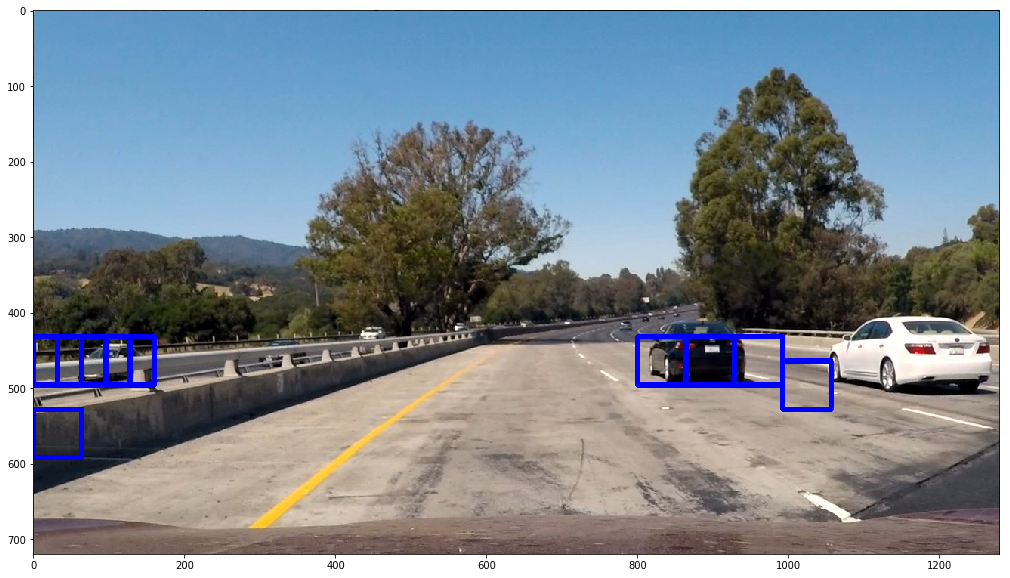

In [24]:
# Read camera image
image = mpimg.imread('test_images/test1.jpg')

draw_image = np.copy(image)
image = image.astype(np.float32)/255

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)

mode = 2
t0 = time.time()

if mode == 1:
    windows = prepare_windows(image,
                              x_start_stop=[None, None],
                              y_start_stop=y_start_stop, 
                              xy_window=(window_size, window_size),
                              xy_overlap=(0.5, 0.5))

    on_windows = search_in_windows(image,
                                   windows,
                                   svc,
                                   X_scaler,
                                   color_space=color_space,
                                   spatial_size=spatial_size,
                                   hist_bins=histogram_bins,
                                   orient=hog_orient,
                                   pix_per_cell=hog_pix_per_cell,
                                   cell_per_block=hog_cell_per_block,
                                   hog_channel=hog_channel,
                                   spatial_feat=enable_spatial_features,
                                   hist_feat=enable_hist_features,
                                   hog_feat=enable_hog_features)

elif mode == 2:
    on_windows = search_in_image(image,
                                 y_start_stop=y_start_stop,
                                 scale=scale,
                                 color_space=color_space,
                                 classifier=svc,
                                 scaler=X_scaler,
                                 window_size=window_size,
                                 hog_channel=hog_channel,
                                 hog_orient=hog_orient,
                                 hog_pix_per_cell=hog_pix_per_cell,
                                 hog_cell_per_block=hog_cell_per_block,
                                 spatial_size=spatial_size,
                                 histogram_bins=histogram_bins,
                                 enable_spatial_features=enable_spatial_features,
                                 enable_hist_features=enable_hist_features,
                                 enable_hog_features=enable_hog_features)

t_detected = time.time() - t0
print(t_detected)
    
print(on_windows)
on_windows_img = draw_boxes(draw_image, on_windows)

f, ax1 = plt.subplots(1,1, figsize=(20,10))
ax1.imshow(on_windows_img)


In [ ]:
## HOT AREAS TO AVOID MULTIPLE DETECTIONS

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
box_list = pickle.load( open( "bbox_pickle.p", "rb" ))

# Read in image similar to one shown above 
image = mpimg.imread('test_image.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


In [ ]:
## OBJECT TRACKING IS COMPLETELY MISSING
# POtrei creeare un oggetto di tipo macchina, con le coordinate del suo centroide e le dimensioni e se è attivato o meno
# poi tenere una lista di questi oggetti, selezionando solo quelli attivi e tracciando dove possono andare